# Ejercicio - CNN
## Redes Pre-Entrenadas

En el último ejercicio hemos construido una red CNN desde cero implementado Keras. Ahora vamos a implementar una red CNN basada en redes pre-entrenadas para comparar los resultados de acuerdo a la arquitectura desarrollada por ustedes.

Existen varias CNN previamente entrenadas disponibles para muchas tareas. Modelos como ResNet, VGG16, InceptionV3 y muchos otros, son altamente eficientes en la mayoría de las tareas de visión por computadora que realizamos actualmente en todas las industrias. En en esta oportunidad, puedes hacer uso de cualquiera de las redes disponibles e implementarla. Debes de realizar las siguientes actividades:

- Seleccionar dos redes pre-entrenadas
- Para cada una de ellas implementar `Transfer Learning`
- Finalmente, implementar `Fine tuning` para las dos alternativas congelando solamente la última capa convolucional disponible.

> Note: Durante el proceso de Fine Tuning no te hagas problema por la precisión del modelo, sino en el proceso de construcción del mismo.

## Dataset

Vas a utilizar el conjunto de datos de reconocimiento de enfermedades de plantas, que contiene `1530` imágenes divididas en conjuntos de entrenamiento, prueba y validación. Las imágenes están etiquetadas como `Saludable` (healty), `Óxido` (rust) y `Polvo` (Powdery) para describir las condiciones de las plantas.

Muy brevemente, cada clase significa lo siguiente:

• Rust: Son enfermedades de las plantas causadas por hongos Pucciniales, que provocan severas deformidades en la planta.

• Powdery: El mildiú polvoroso es causado por el hongo Erysphales y representa una amenaza para la agricultura y la horticultura al reducir el rendimiento de los cultivos.

• Healty: Naturalmente, son las plantas que están libres de enfermedades.


Puedes obtener el link de descarga [aquí](https://drive.google.com/drive/folders/1e24quFWVPK6hWeIbrTh2y8z2lgpplPcE?usp=drive_link)

>NOTE: Se recomienda crear un link dentro de drive (`My Drive`) o descargar los archivos y subirlos a tu drive tal cual la estructura que se muestra en ese link.


In [1]:
#!pip install catboost
#!pip install optuna

In [2]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# Efficient Looping
import itertools

# Traceback for diagnosis
import traceback

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest
import math

# Feature Selection
from sklearn.feature_selection import (
    RFECV, SelectKBest, chi2, f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)

# Machine Learning Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin

# Preprocessing data
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Model Selection for Cross Validation
from sklearn.model_selection import (
    StratifiedKFold, KFold,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, TimeSeriesSplit
)

# Machine Learning metrics
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    cohen_kappa_score,
    make_scorer,
    roc_curve,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

# ML regressors
from sklearn.linear_model import HuberRegressor,RANSACRegressor, TheilSenRegressor, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.ensemble import (
    HistGradientBoostingRegressor, StackingRegressor,
    AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, StackingRegressor, VotingRegressor
    )
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# ML classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import (
    HistGradientBoostingClassifier, AdaBoostClassifier,
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier,ExtraTreesClassifier
    )
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Clustering algorithms
from sklearn.cluster import KMeans

# Fine-tuning
import optuna

# Randomizer
import random

# Encoder of categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# OS
import os

# Image package
from PIL import Image

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [4]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

In [5]:
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images, title, subtitle):
    '''
    This functions helps to plot a matrix of images in a list
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)

    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))

    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
        #template=template
    )
    fig.show()

In [6]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


## Explorando los datos

Antes de construir nuestra red neuronal convolucional, resulta útil realizar un análisis breve pero eficiente de los datos que tenemos a mano. Comencemos cargando los directorios para cada conjunto.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Loading training, testing, and validation directories
train_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease/train'# TODO completar con path
test_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease/test'# TODO completar con path
val_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease/validation' # TODO completar con path

También podemos contar los archivos dentro de cada subcarpeta para calcular el total de datos que tenemos para entrenamiento y prueba, así como medir el grado de desequilibrio de clases.

In [9]:
# Giving names to each directory
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
    }

# Naming subfolders
subfolders = ['healthy', 'powdery', 'rust']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Train/healthy: 460

Train/powdery: 430

Train/rust: 434

  Total: 1324
--------------------------------------------------------------------------------

Test/healthy: 50

Test/powdery: 50

Test/rust: 50

  Total: 150
--------------------------------------------------------------------------------

Validation/healthy: 20

Validation/powdery: 20

Validation/rust: 20

  Total: 60
--------------------------------------------------------------------------------


Tenemos un total de 1322 archivos dentro del directorio Train y no hay grandes desequilibrios entre clases. Una pequeña variación entre ellos está bien y una métrica simple como la Precisión puede ser suficiente para medir el desempeño.

Para el conjunto de prueba, tenemos un total de 150 imágenes, mientras que el conjunto de validación consta de 60 imágenes en total. Ambos conjuntos tienen un equilibrio de clases perfecto.
          
Para el conjunto de prueba, tenemos un total de 150 imágenes, mientras que el conjunto de validación consta de 60 imágenes en total. Ambos conjuntos tienen un equilibrio de clases perfecto.

In [10]:
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)

if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions: {unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


Found 8 unique image dimensions: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)}


Tenemos 8 dimensiones diferentes en todo el conjunto de datos. En la siguiente celda, comprobaré la distribución de estas dimensiones en los datos.

In [11]:
# Checking if all the images in the dataset have the same dimensions
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1

for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (4000, 2672): 1132 images

Dimension (4000, 3000): 88 images

Dimension (2421, 2279): 1 images

Dimension (2592, 1728): 127 images

Dimension (5184, 3456): 97 images

Dimension (4608, 3456): 72 images

Dimension (4032, 3024): 16 images

Dimension (3901, 2607): 1 images


Parece que la mayoría de las imágenes tienen dimensiones de 4000x2672, que es una forma rectangular. Podemos concluir que, debido a las diferencias en las dimensiones, necesitaremos aplicar algún preprocesamiento a los datos.

Primero, vamos a cambiar el tamaño de las imágenes para que todas tengan la misma forma. Luego, transformaremos la entrada de forma rectangular a forma cuadrada.

In [12]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)

            if img_array.dtype == 'uint8':
                all_uint8 = False

            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False

if all_uint8:
    print(" - All images are of data type uint8\n")
else:
    print(" - Not all images are of data type uint8\n")

if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - Not all images are of data type uint8

 - All images have pixel values ranging from 0 to 255


Aunque no todas las imágenes son del mismo tipo de datos, uint8, es bastante fácil garantizar que tendrán el mismo tipo de datos una vez que carguemos imágenes en conjuntos de datos. Sin embargo, confirmamos que todas las imágenes tienen valores de píxeles que van de 0 a 255, lo cual es una gran noticia.

Antes de pasar al paso de preprocesamiento, tracemos algunas imágenes de cada clase para ver cómo se ven.

In [13]:
# Loading the directory for each class in the training dataset
train_healthy_dir = train_dir + "/" + 'healthy'
train_rust_dir = train_dir + "/" + 'rust'
train_powdery_dir = train_dir + "/" + 'powdery'

# Selecting 2 random pictures from each directory
healthy_files = random.sample(os.listdir(train_healthy_dir), 2)
rust_files = random.sample(os.listdir(train_rust_dir), 2)
powdery_files = random.sample(os.listdir(train_powdery_dir), 2)

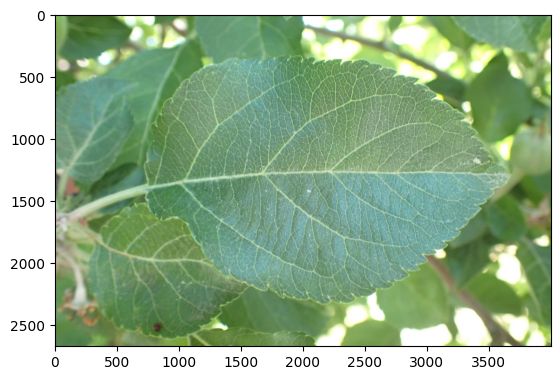

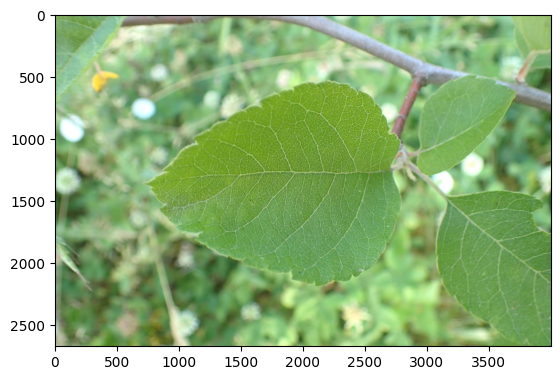

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in (healthy_files):
    img = mpimg.imread(train_healthy_dir + '/' + i)
    imgplot = plt.imshow(img)
    plt.show()

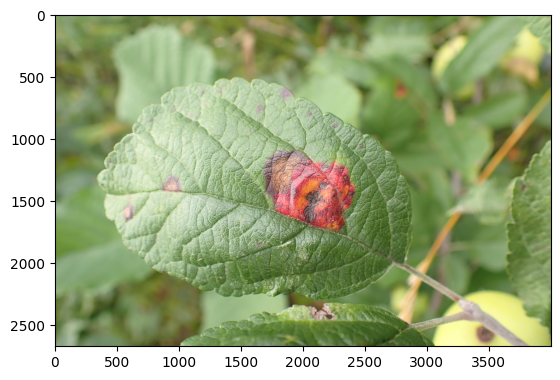

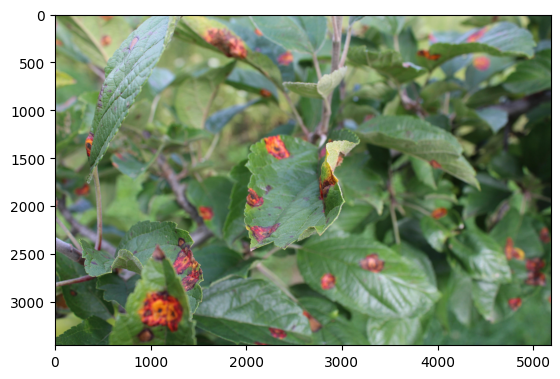

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in (rust_files):
    img = mpimg.imread(train_rust_dir + '/' + i)
    imgplot = plt.imshow(img)
    plt.show()

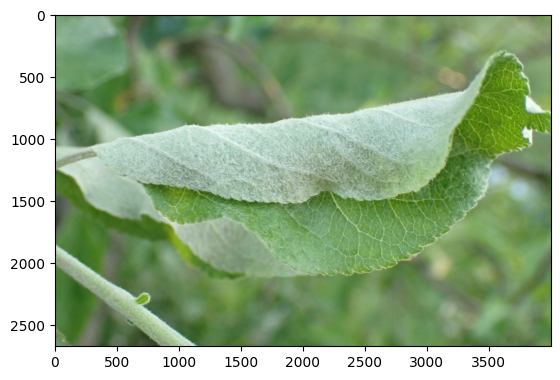

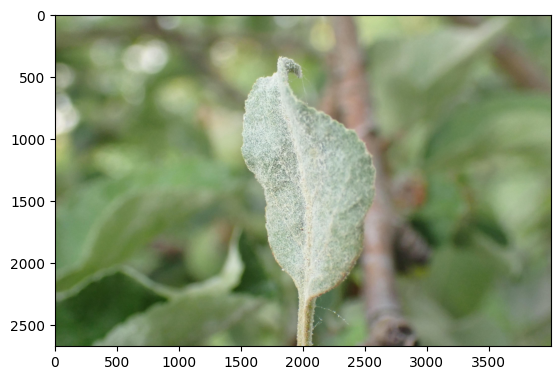

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in (powdery_files):
    img = mpimg.imread(train_powdery_dir + '/' + i)
    imgplot = plt.imshow(img)
    plt.show()

## Preprocessing

Para quienes están familiarizados con los datos tabulares, el preprocesamiento es probablemente uno de los pasos más desalentadores al tratar con redes neuronales y datos no estructurados.

Esta tarea puede ser bastante sencilla utilizando image_dataset_from_directory de TensorFlow, que carga imágenes de los directorios como un conjunto de datos de TensorFlow. Este conjunto de datos resultante se puede manipular para realizar lotes, barajar, aumentar y varios otros pasos de preprocesamiento.

Le sugiero que consulte este enlace para obtener más información sobre la función `image_dataset_from_directory`.

In [17]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['healthy', 'powdery', 'rust'],
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (256, 256), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 1324 files belonging to 3 classes.


In [18]:
# Creating a dataset for the Test data
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['healthy', 'powdery', 'rust'],
    batch_size = 128,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 150 files belonging to 3 classes.


In [19]:
# Creating a dataset for the validation data
validation = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['healthy', 'powdery', 'rust'],
    batch_size = 128,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 60 files belonging to 3 classes.


Hemos capturado con éxito todos los archivos dentro de cada conjunto para cada una de las tres clases. También podemos imprimir estos conjuntos de datos para comprender mejor su estructura.

In [20]:
print('\nTraining Dataset:', train)
print('\nTesting Dataset:', test)
print('\nValidation Dataset:', validation)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


Exploremos un poco más a fondo lo que significa toda la información anterior.

• `BatchDataset`: Indica que el conjunto de datos devuelve datos en lotes.

• `element_spec`: describe la estructura de los elementos del conjunto de datos.

• `TensorSpec`(shape=(Ninguno, 256, 256, 3), dtype=tf.float32, nombre = Ninguno): esto representa las características, en este caso las imágenes, en el conjunto de datos. Ninguno representa el tamaño del lote, que aquí es Ninguno porque puede variar dependiendo de cuántas muestras tengamos en el último lote; 256, 256 representa el alto y ancho de las imágenes; 3 es el número de canales en las imágenes, lo que indica que son imágenes RGB. Por último, dtype=tf.float32 nos dice que el tipo de datos de los píxeles de la imagen es un punto flotante de 32 bits.

• `TensorSpec`(shape=(None, 3), dtype=tf.float32, name=None): esto representa las etiquetas/objetivos de nuestro conjunto de datos. Aquí Ninguno se refiere al tamaño del lote; 3 se refiere al número de etiquetas en el conjunto de datos; mientras que dtype=tf.float32 también es un punto flotante de 32 bits.

Al utilizar la función image_dataset_from_directory, hemos podido preprocesar automáticamente algunos aspectos de los datos. Por ejemplo, todas las imágenes ahora son del mismo tipo de datos, `tf.float32`. Al establecer image_size = (256, 256), nos hemos asegurado de que todas las imágenes tengan las mismas dimensiones, `256 x 256`.

Otro paso importante para el preprocesamiento es garantizar que los valores de píxeles de nuestras imágenes estén dentro de un rango de 0 a 1. El método image_dataset_from_directory ya realizó algunas transformaciones, pero los valores de píxeles todavía están en el rango de 0 a 255.

In [21]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


Para llevar los valores de píxeles al rango de 0 a 1, podemos usar fácilmente una de las capas de preprocesamiento de Keras, `tf.keras.layers.Rescaling`.

In [22]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

In [23]:
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y))
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

Ahora podemos visualizar una vez más los valores mínimo y máximo de píxeles en el conjunto de validación.

In [24]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


## Data Augmentation

Cuando se trabaja con datos de imágenes, suele ser una buena práctica introducir artificialmente cierta diversidad en la muestra aplicando transformaciones aleatorias a las imágenes utilizadas en el entrenamiento. Esto es bueno porque ayuda a exponer el modelo a una variedad más amplia de imágenes y evita el sobreajuste.

Keras tiene alrededor de siete capas diferentes para aumentar los datos de imágenes. Estos son:

• `tf.keras.layers.RandomCrop`: esta capa elige aleatoriamente una ubicación para recortar imágenes hasta un tamaño objetivo.

• `tf.keras.layers.RandomFlip`: esta capa voltea imágenes aleatoriamente horizontal o verticalmente según el atributo de modo.

• `tf.keras.layers.RandomTranslation`: esta capa aplica traducciones aleatoriamente a cada imagen durante el entrenamiento de acuerdo con el atributo fill_mode.

• `tf.keras.layers.RandomBrightness`: esta capa aumenta/reduce aleatoriamente el brillo de las imágenes RGB de entrada.

• `tf.keras.layers.RandomRotation: esta capa rota aleatoriamente las imágenes durante el entrenamiento y también llena los espacios vacíos según el atributo fill_mode.

• `tf.keras.layers.RandomZoom`: esta capa acerca o aleja aleatoriamente cada eje de cada imagen de forma independiente durante el entrenamiento.

• `tf.keras.layers.RandomContrast`: esta capa ajusta aleatoriamente el contraste mediante un factor aleatorio durante el entrenamiento dentro o fuera de cada eje de cada imagen de forma independiente durante el entrenamiento.

Para esta tarea, aplicaremos `RandomRotation`, `RandomContrast` y `RandomBrightness` a nuestras imágenes.

In [25]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

También podemos usar input_shape como ejemplo para construir la tubería de arriba y trazarla a continuación para ilustrar su apariencia.

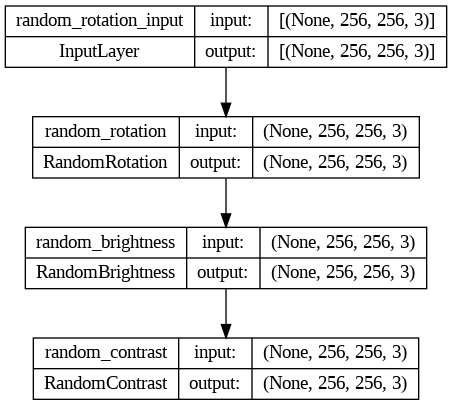

In [26]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

Vamos a conectar este canal de aumento de datos a nuestra red neuronal convolucional. Es importante recordar que la canalización de aumento de datos está inactiva durante las pruebas y las muestras de entrada solo se aumentarán durante `fit()`, no cuando se llama a `predict()`.

## Building the Convolutional Neural Network from a pre-trained network

## Resnet50/Resnet152 - Transfer Learning
>NOTE: (Seleccionar la red pre entrenada que desee, aquí solo se da un ejemplo)

In [27]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50 (include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
)#TODO
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [28]:
# conectarlo a nueva parte densa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
# Flattening tensors
pre_trained_model.add(Flatten())

# Fully-Connected Layers
pre_trained_model.add(Dense(1024))
pre_trained_model.add(Activation('relu')) #TODO
pre_trained_model.add(Dropout(0.5))

# Output Layer
pre_trained_model.add(Dense(3, activation = 'softmax')) #TODO Classification layer

pre_trained_model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', #TODO Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [29]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 10, mode = 'auto',
                              restore_best_weights = True)

In [30]:
save_path= '/content/drive/MyDrive/Colab Notebooks/'
checkpoint = ModelCheckpoint(save_path+'best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

csv_logger = tf.keras.callbacks.CSVLogger(save_path + "history_log.csv",
                                          separator=";",
                                          append=False)

In [31]:
pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 157809539 (602.00 MB)
Trainable params: 

In [32]:
# Training and Testing Model
try:
    history = pre_trained_model.fit(
        train, epochs = 15,
        validation_data = test,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/15
83/83 [==============================] - 98s 938ms/step - loss: 3.2700 - accuracy: 0.3610 - val_loss: 1.1087 - val_accuracy: 0.3333
Epoch 2/15
83/83 [==============================] - 98s 1s/step - loss: 1.1107 - accuracy: 0.3565 - val_loss: 1.0953 - val_accuracy: 0.4133
Epoch 3/15
83/83 [==============================] - 74s 836ms/step - loss: 1.1059 - accuracy: 0.3648 - val_loss: 1.0930 - val_accuracy: 0.3600
Epoch 4/15
83/83 [==============================] - 72s 792ms/step - loss: 1.0896 - accuracy: 0.3731 - val_loss: 1.1185 - val_accuracy: 0.3333
Epoch 5/15
83/83 [==============================] - 70s 774ms/step - loss: 1.0870 - accuracy: 0.3807 - val_loss: 1.0863 - val_accuracy: 0.3533
Epoch 6/15
83/83 [==============================] - 72s 818ms/step - loss: 1.0832 - accuracy: 0.3746 - val_loss: 1.0790 - val_accuracy: 0.4133
Epoch 7/15
83/83 [==============================] - 89s 1s/step - loss: 1.0833 - accuracy: 0.3776 - val_loss: 1.0842 - val_accuracy: 0.5733
Epoch

Después de compilar el modelo, definiras una parada temprana y un punto de control del modelo.

La parada temprana tiene el propósito de interrumpir el proceso de capacitación cuando una determinada métrica deja de mejorar durante un período de tiempo. En este caso, voy a configurar el método EarlyStopping para monitorear la precisión en el conjunto de pruebas y detener el proceso de entrenamiento si no logramos ninguna mejora después de 5 épocas.

Model Checkpoint garantizará que solo se guarden los mejores pesos y también definiremos los mejores pesos de acuerdo con la precisión del modelo en el conjunto de prueba.

In [33]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
#fig.show()

fig.show(renderer="colab")

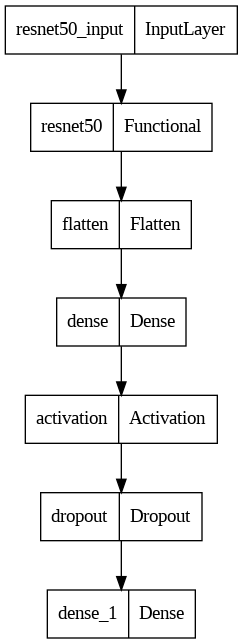

In [34]:
tf.keras.utils.plot_model(pre_trained_model) #TODO Plotting model

In [35]:
pre_trained_model.summary() #TODO Printing model summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 157809539 (602.00 MB)
Trainable params: 

## Validating Performance

In [36]:
# Loading best weights
pre_trained_model.load_weights('best_model.h5')

In [37]:
preds = pre_trained_model.predict(validation)  # Running model on the validation dataset
val_loss, val_acc = pre_trained_model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

1/1 [==============================] - 3s 3s/step - loss: 1.0939 - accuracy: 0.4000

Validation Loss:  1.0938897132873535

Validation Accuracy:  40.0 %


Picture of a Powdery Plant: 



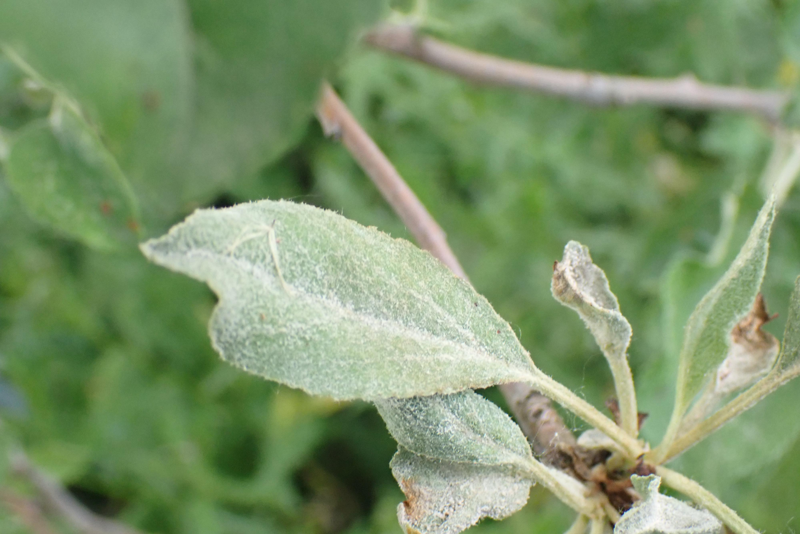

In [38]:
# Loading an image from the Validation/ Powdery directory
image_path = '/content/drive/MyDrive/Colab Notebooks/plant_disease/validation/powdery/9b6a318cc5721d73.jpg'#TODO complete path
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Powdery Plant: \n')
resized_img

Picture of a Rust Plant: 



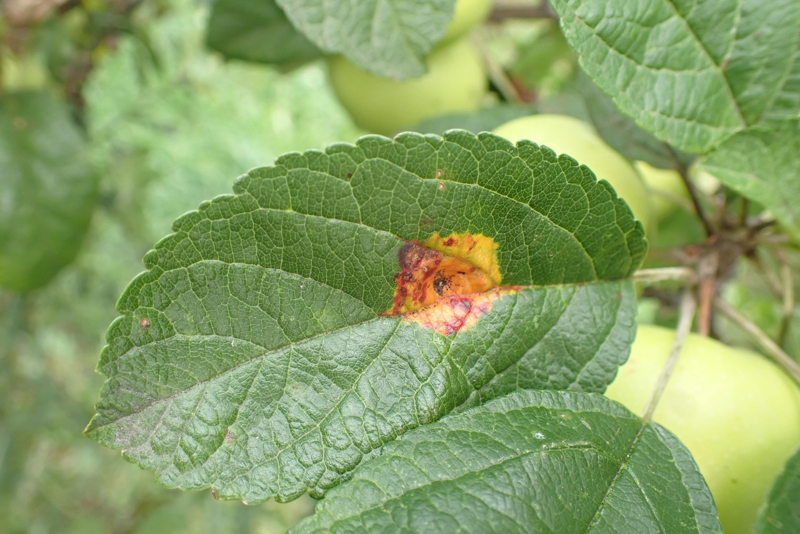

In [39]:
# Loading an image from the Validation/ Rust directory
image_path = '/content/drive/MyDrive/Colab Notebooks/plant_disease/validation/rust/8152cfbd5a28b5d2.jpg'#TODO complete path
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Rust Plant: \n')
resized_img

In [42]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = pre_trained_model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['healthy', 'powdery', 'rust'] #TODO labels

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 2s 2s/step

Predicted Class: rust

Confidence Score: 0.34257182478904724


Picture of a Healthy Plant: 



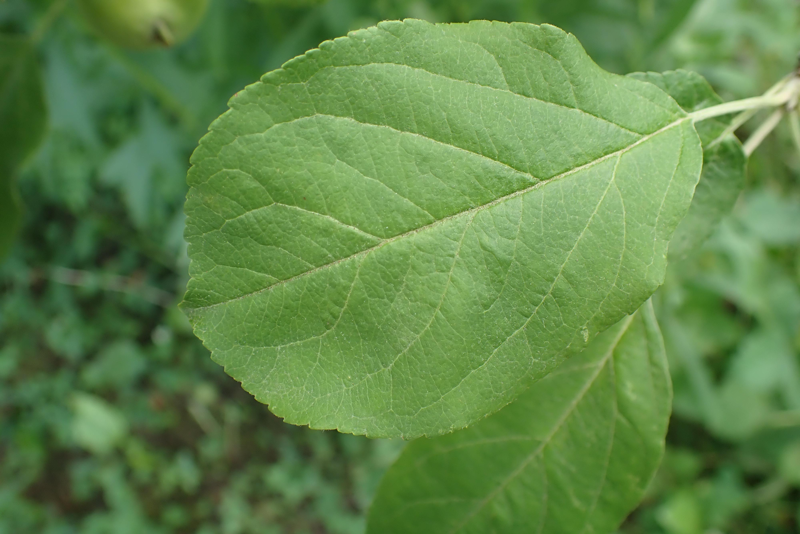

In [44]:
# Loading an image from the Validation/ Healthy directory
image_path = '/content/drive/MyDrive/Colab Notebooks/plant_disease/validation/healthy/9c99786a63786571.jpg' #TODO complete path
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Healthy Plant: \n')
resized_img

In [46]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = pre_trained_model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['healthy', 'powdery', 'rust'] #TODO labels

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 0s 103ms/step

Predicted Class: rust

Confidence Score: 0.33820992708206177


In [47]:
pre_trained_model.save('plant_disease_classifier.h5') # Saving model

## Restnet50/Resnet152 - Fine Tuning
>NOTE: (Seleccionar la red pre entrenada que desee, aquí solo se da un ejemplo)